In [2]:
import networkx as nx

In [5]:
G = nx.read_gexf("./data/graph.gexf")

## Find how many packages are covered by the ones with GitHub data
We do this step to evaluate how much impact the selected, analyzed packages have on the whole registry.

In [20]:
import csv
import matplotlib.pyplot as plt

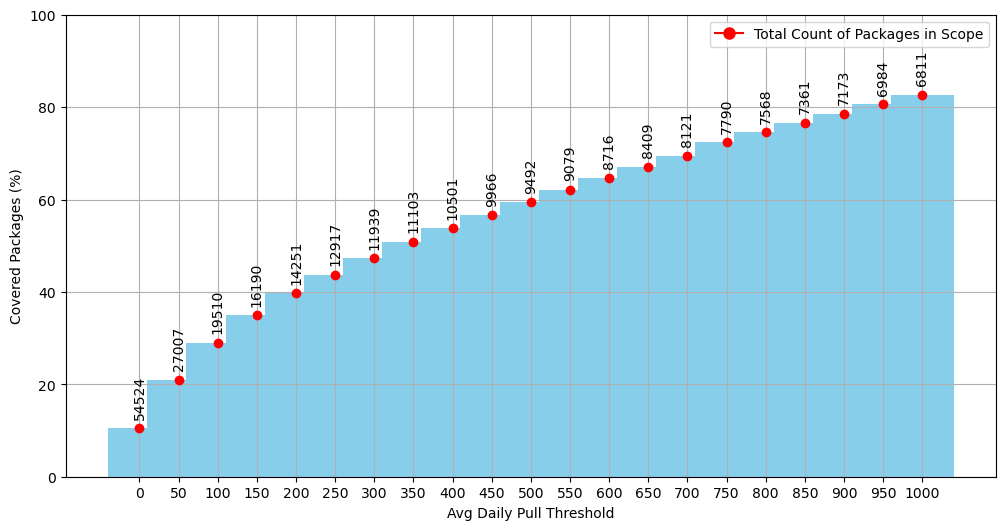

In [39]:
G_reversed = nx.reverse(G)

for node in G_reversed.nodes():
    G_reversed.nodes[node]['covered'] = False

def dfs(node):
    if G_reversed.nodes[node]['covered']:
        return
    G_reversed.nodes[node]['covered'] = True
    for neighbor in G_reversed.predecessors(node):
        dfs(neighbor)

with open('./data/gh_packages.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        name = row['pkg_name']
        if not name:
            continue
        dfs(name)

covered_percentages = []
node_counts = []
avg_daily_thresholds = list(range(0, 1001, 50))
for min_avg_daily in avg_daily_thresholds:
    nodes_to_remove = [node for node, data in G_reversed.nodes(data=True) if data.get('avg_daily', 0) < min_avg_daily]
    G_reversed.remove_nodes_from(nodes_to_remove)
    total_nodes = G_reversed.number_of_nodes()
    node_counts.append(total_nodes)
    covered_count = sum(1 for node in G_reversed.nodes() if G_reversed.nodes[node]['covered'])
    covered_percentages.append(covered_count / total_nodes * 100)
    
plt.figure(figsize=(12, 6))
bars = plt.bar(avg_daily_thresholds, covered_percentages, width=80, color='skyblue')
plt.xlabel('Avg Daily Pull Threshold')
plt.ylabel('Covered Packages (%)')
plt.xticks(avg_daily_thresholds)
plt.grid()
for bar, count in zip(bars, node_counts):
    yval = bar.get_height()
    plt.plot(bar.get_x() + bar.get_width()/2, yval, marker='o', markersize=6, color='red')
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, str(count), ha='center', va='bottom', rotation=90)
plt.plot([], [], marker='o', markersize=8, color='red', label='Total Count of Packages in Scope')
plt.legend()
plt.ylim(0, 100)
plt.show()